In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import io

%matplotlib inline

In [2]:
def letter_frequency_vector(text):
    """
    Convert input text into a 26-dimensional vector representing letter frequencies.
    All non-letter characters are removed and the frequencies are normalized.
    """
    text = ''.join(filter(str.isalpha, text.lower()))
    freq = np.zeros(26)
    if len(text) == 0:
        return freq
    for char in text:
        idx = ord(char) - ord('a')
        if 0 <= idx < 26:
            freq[idx] += 1
    return freq / len(text)


In [3]:
# Load dataset from sentences.csv (assumes header: text,label)
df = pd.read_csv(
    "/Users/jakubgralinski/Desktop/studies/PJATK_25_Summer_Semester/NAI/SingleLayerNeuralNetwork/NAI-03/src/main/resources/sentences.csv")
print("Dataset head:")
print(df.head())

Dataset head:
                                                text    label
0     I enjoy reading books and learning new things.  English
1   The weather is beautiful today and I feel happy.  English
2  Technology drives progress and innovation in o...  English
3     Programming is both challenging and rewarding.  English
4      Music and art inspire creativity and passion.  English


In [4]:
# Compute letter-frequency features
df['features'] = df['text'].apply(letter_frequency_vector)
X = np.vstack(df['features'].values)
y = df['label'].values

# Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
# Split the data: 70% training, 30% test
X_train, X_test, y_train, y_test, texts_train, texts_test = train_test_split(
    X, y_encoded, df['text'], test_size=0.3, random_state=42
)
# Train a scikit-learn Perceptron classifier
sklearn_clf = SklearnPerceptron(max_iter=1000, tol=1e-3, random_state=42)
sklearn_clf.fit(X_train, y_train)
y_pred_sklearn = sklearn_clf.predict(X_test)
# Evaluate scikit-learn classifier
acc_sklearn = accuracy_score(y_test, y_pred_sklearn)
prec_sklearn = precision_score(y_test, y_pred_sklearn, average='macro')
rec_sklearn = recall_score(y_test, y_pred_sklearn, average='macro')
f1_sklearn = f1_score(y_test, y_pred_sklearn, average='macro')

print("Sklearn Accuracy:", acc_sklearn)
print("Sklearn Precision:", prec_sklearn)
print("Sklearn Recall:", rec_sklearn)
print("Sklearn F1:", f1_sklearn)

Sklearn Accuracy: 0.9907407407407407
Sklearn Precision: 0.7435897435897436
Sklearn Recall: 0.75
Sklearn F1: 0.7467532467532467


/Users/jakubgralinski/Desktop/studies/PJATK_25_Summer_Semester/NAI/NAI_perceptron_implementation/NAI_perceptron_mapping/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
# Read the Java results from the CSV file.
with open(
        "/Users/jakubgralinski/Desktop/studies/PJATK_25_Summer_Semester/NAI/SingleLayerNeuralNetwork/NAI-03/results.csv",
        "r") as f:
    lines = f.read().splitlines()

# Find the index where metrics start (assuming the metrics section starts with "Overall Accuracy")
metrics_start = None
for i, line in enumerate(lines):
    if line.startswith("Overall Accuracy"):
        metrics_start = i
        break

if metrics_start is None:
    raise ValueError("Metrics section not found in CSV.")

# Extract the metrics lines and load them into a DataFrame.
metrics_lines = lines[metrics_start:]
metrics_data = "\n".join(metrics_lines)
# Assign headers
java_results = pd.read_csv(io.StringIO(metrics_data), header=None, names=["metric", "Overall", "extra"])
java_results = java_results.drop(columns="extra")
java_results.set_index("metric", inplace=True)

print("Raw Java Results:")
print(java_results)

Raw Java Results:
                   Overall
metric                    
Overall Accuracy       1.0
Precision_French       1.0
Recall_French          1.0
FMeasure_French        1.0
Precision_label        0.0
Recall_label           0.0
FMeasure_label         0.0
Precision_Spanish      1.0
Recall_Spanish         1.0
FMeasure_Spanish       1.0
Precision_English      1.0
Recall_English         1.0
FMeasure_English       1.0


In [6]:
# Aggregate Java metrics to match scikit-learn macro averages
java_accuracy = float(java_results.loc["Overall Accuracy", "Overall"])

# For Precision, Recall, and F1, we average over classes.
classes = ["French", "Spanish", "English"]

java_precision = np.mean([float(java_results.loc[f"Precision_{cls}", "Overall"]) for cls in classes])
java_recall = np.mean([float(java_results.loc[f"Recall_{cls}", "Overall"]) for cls in classes])
java_f1 = np.mean([float(java_results.loc[f"FMeasure_{cls}", "Overall"]) for cls in classes])

java_aggregated = pd.DataFrame({
    'metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'Overall': [java_accuracy, java_precision, java_recall, java_f1]
}).set_index('metric')

print("Aggregated Java Results:")
print(java_aggregated)

Aggregated Java Results:
           Overall
metric            
Accuracy       1.0
Precision      1.0
Recall         1.0
F1             1.0


In [7]:
# Create a DataFrame for scikit-learn results
sklearn_results = pd.DataFrame({
    'metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'Overall': [acc_sklearn, prec_sklearn, rec_sklearn, f1_sklearn]
}).set_index('metric')

print("Sklearn Results:")
print(sklearn_results)

Sklearn Results:
            Overall
metric             
Accuracy   0.990741
Precision  0.743590
Recall     0.750000
F1         0.746753


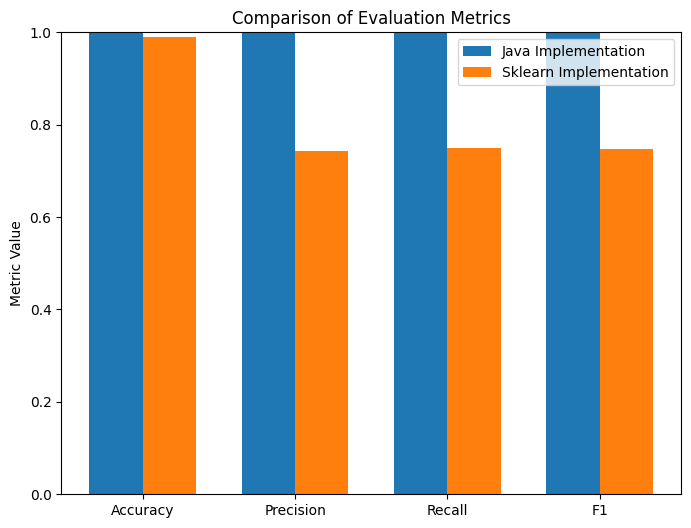

In [8]:
# Plot a comparison of the metrics between the Java implementation and scikit-learn
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width / 2, java_aggregated.loc[metrics, 'Overall'], width, label='Java Implementation')
ax.bar(x + width / 2, sklearn_results.loc[metrics, 'Overall'], width, label='Sklearn Implementation')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Evaluation Metrics')
ax.legend()
ax.set_ylim(0, 1)
plt.show()